In [6]:
import onnx, torch
from onnx2pytorch import ConvertModel

In [ ]:
effnet_model = onnx.load("model/discogs-effnet-bsdynamic-1.onnx")
effnet_model = ConvertModel(effnet_model)

c:\Users\pafitis\envs\dev\Lib\site-packages\onnx2pytorch\convert\layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


In [12]:
torch.save(pytorch_model,"model/discogs-effnet-bsdynamic-1.pt")

In [4]:
import torch
model = torch.load('model/discogs-effnet-bsdynamic-1.pt')

C:\Users\pafitis\AppData\Local\Temp\ipykernel_20416\1987439094.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model/discogs-effnet-bsdynamic-1.pt')


In [5]:
model

ConvertModel(
  (Unsqueeze_361): Unsqueeze()
  (Conv_651): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Sigmoid_364): Sigmoid()
  (Mul_365): OperatorWrapper()
  (Conv_654): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
  (Sigmoid_368): Sigmoid()
  (Mul_369): OperatorWrapper()
  (GlobalAveragePool_370): GlobalAveragePool()
  (Conv_371): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  (Sigmoid_372): Sigmoid()
  (Mul_373): OperatorWrapper()
  (Conv_374): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
  (Sigmoid_375): Sigmoid()
  (Mul_376): OperatorWrapper()
  (Conv_657): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (Conv_660): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
  (Sigmoid_381): Sigmoid()
  (Mul_382): OperatorWrapper()
  (Conv_663): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96)
  (Sigmoid_385): Sigmoid()
  (Mul_386): OperatorWrapper()
  (GlobalAveragePool_387): GlobalAveragePool(

c:\Users\pafitis\envs\dev\Lib\site-packages\onnx2pytorch\convert\layer.py:30: 
UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors.
This means writing to this tensor will result in undefined behavior. 
You may want to copy the array to protect its data or make it writable before converting it to a tensor.
This type of warning will be suppressed for the rest of this program. 
(Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))

In [19]:
import discogs_client
import yaml

with open('configs/constants.yaml', 'r') as file:
    keys = yaml.load(file, Loader=yaml.SafeLoader)
with open('configs/run_config.yaml', 'r') as file:
    run_config = yaml.load(file, Loader=yaml.SafeLoader)
with open('configs/params_metadata.yaml', 'r') as file:
    params = yaml.load(file, Loader=yaml.SafeLoader)
with open('configs/yt_dlp.yaml', 'r') as file:
    yt_params = yaml.load(file, Loader=yaml.SafeLoader)

client = discogs_client.Client('digger/0.1', user_token=keys['DISCOGS_KEY'])

In [1]:
from scipy import signal
import numpy as np
import librosa
import torch
import torchaudio

In [2]:
pipeline = torchaudio.pipelines.HUBERT_BASE
model = pipeline.get_model()

In [7]:
wave, sr = torchaudio.load('temp/Befog - Fractus [fK7FXVqcmQU].wav')
waveform = torchaudio.functional.resample(wave, sr, pipeline.sample_rate)

# Extract acoustic features
# features, _ = model.extract_features(waveform)

In [9]:
features, _ = model.extract_features(waveform)

: 

In [7]:
import matplotlib.pyplot as plt

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

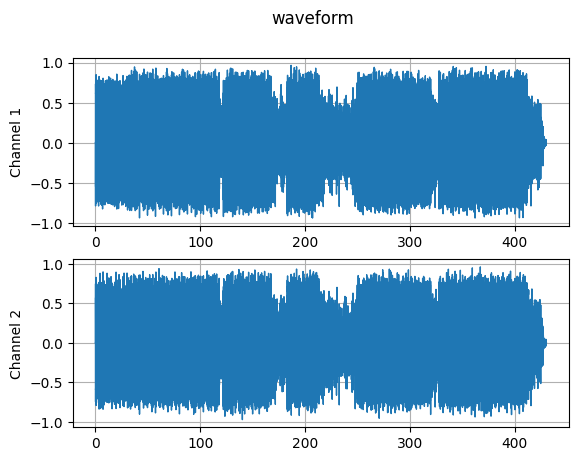

In [8]:
plot_waveform(wave, sr)